In [4]:
import csv
from datetime import datetime
from pysnmp.hlapi import *
import matplotlib.pyplot as plt
import pandas as pd


In [5]:
target_ip = '192.168.11.100'
community = 'omegadejdar'
port = 161
oids = {
    'WAN_IN': '1.3.6.1.2.1.2.2.1.10.2',     # ifInOctets.2
    'WAN_OUT': '1.3.6.1.2.1.2.2.1.16.8',    # ifOutOctets.2
    'SYS_UPTIME': '1.3.6.1.2.1.1.3.0'
}




In [6]:
def snmp_get(oid):
    iterator = getCmd(
        SnmpEngine(),
        CommunityData(community, mpModel=0),
        UdpTransportTarget((target_ip, port), timeout=3, retries=2),
        ContextData(),
        ObjectType(ObjectIdentity(oid))
    )
    errorIndication, errorStatus, errorIndex, varBinds = next(iterator)
    if errorIndication or errorStatus:
        return None
    for varBind in varBinds:
        value = varBind[1]
        # Pokud je to číslo, vrať jako int
        if isinstance(value, (int, float)):
            return int(value)
        # Pokud je to řetězec, vrať jako string
        elif hasattr(value, 'prettyPrint'):
            return value.prettyPrint()
        else:
            return str(value)

In [7]:
import os
import csv
from datetime import datetime

def safe_bytes_to_mb(current, previous=None, unit='binary', max_counter=2**32):
    """
    Bezpečný převod bajtů na MB s podporou přetečení a volbou jednotky.

    Args:
        current (int/str): aktuální hodnota SNMP čítače
        previous (int/str): předchozí hodnota (volitelné)
        unit (str): 'binary' (MiB) nebo 'decimal' (MB)
        max_counter (int): maximální hodnota čítače (default 2^32)

    Returns:
        float: přepočtená hodnota v MB nebo None při chybě
    """
    try:
        current = int(current)
        if previous is not None:
            previous = int(previous)
            # Detekce přetečení
            if current >= previous:
                delta = current - previous
            else:
                delta = (max_counter - previous) + current
        else:
            delta = current  # jen převod jedné hodnoty

        # Přepočet
        if unit == 'binary':
            return round(delta / (1024 * 1024), 2)
        elif unit == 'decimal':
            return round(delta / 1_000_000, 2)
        else:
            return None
    except (TypeError, ValueError):
        return None



# Získání dat
timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
raw_isp_in = snmp_get(oids['WAN_IN'])
raw_lan_out = snmp_get(oids['WAN_OUT'])
raw_isp_uptime = snmp_get(oids['SYS_UPTIME'])

# Převod hodnot
isp_in_mb = safe_bytes_to_mb(raw_isp_in)
lan_out_mb = safe_bytes_to_mb(raw_lan_out)
# isp_speed_mbps = safe_bytes_to_mbps(raw_isp_uptime)


def snmp_ticks_to_hours(ticks):
    """
    Converts SNMP sysUpTime (in hundredths of seconds) to hours with two decimal places.
    Example: 87301900 → 242.51 hours
    """
    try:
        ms = int(float(ticks)) * 10  # 1 tick = 10 ms
        return round(ms / 3_600_000, 2)  # ms → hours
    except (TypeError, ValueError):
        return None


    
isp_uptime = snmp_ticks_to_hours(raw_isp_uptime)

# Zápis do CSV s hlavičkou (i když soubor existuje, ale je prázdný)
file_path = 'traffic_log.csv'
write_header = not os.path.exists(file_path) or os.path.getsize(file_path) == 0

with open(file_path, mode='a', newline='') as file:
    writer = csv.writer(file)
    if write_header:
        writer.writerow(['Time', 'ISP_IN_MB', 'LAN_OUT_MB', 'ISP_uptime'])
    writer.writerow([timestamp, isp_in_mb, lan_out_mb, isp_uptime])


In [8]:
isp_uptime

283.79

In [9]:
import pandas as pd
import os

# ---------- Cesta k souboru ----------
file_path = 'traffic_log.csv'
output_path = 'traffic_log_dif.csv'

# ---------- Načtení CSV ----------
df = pd.read_csv(file_path, names=['Time', 'ISP_IN_MB', 'LAN_OUT_MB', 'ISP_uptime'])

# ---------- Odstranění duplicitní hlavičky ----------
df = df[df['Time'] != 'Time']

# ---------- Převedení typů ----------
df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
df['ISP_IN_MB'] = pd.to_numeric(df['ISP_IN_MB'], errors='coerce')
df['LAN_OUT_MB'] = pd.to_numeric(df['LAN_OUT_MB'], errors='coerce')
df['ISP_uptime'] = pd.to_numeric(df['ISP_uptime'], errors='coerce')

# ---------- Funkce pro výpočet rozdílu s přetečením ----------
def safe_diff(series, max_counter_mb=4096):
    """
    Vypočítá rozdíl mezi hodnotami v sérii s ošetřením přetečení SNMP čítače (např. po 4 GB).
    Předpokládá, že vstupní hodnoty jsou v MB.
    """
    diffs = []
    prev = None
    for curr in series:
        if pd.isna(curr) or pd.isna(prev):
            diffs.append(None)
        else:
            if curr >= prev:
                delta = curr - prev
            else:
                delta = (max_counter_mb - prev) + curr
            diffs.append(round(delta, 2))
        prev = curr
    return pd.Series(diffs, index=series.index)

# ---------- Výpočet rozdílů ----------
df['Delta_ISP_IN_MB'] = safe_diff(df['ISP_IN_MB'])
df['Delta_LAN_OUT_MB'] = safe_diff(df['LAN_OUT_MB'])
df['Delta_Time_hr'] = df['Time'].diff().dt.total_seconds().div(3600).round(2)

# ---------- Výstup ----------
print(df)
df.to_csv(output_path, index=False)


                  Time  ISP_IN_MB  LAN_OUT_MB  ISP_uptime  Delta_ISP_IN_MB  \
1  2025-10-05 13:11:00    3118.84        0.00         NaN              NaN   
2  2025-10-06 10:27:00    3763.39        0.00         NaN           644.55   
3  2025-10-06 11:50:14    3783.47        0.00         NaN            20.08   
4  2025-10-06 17:09:56    3819.19        0.00         NaN            35.72   
5  2025-10-06 17:40:04    3840.88      953.76         NaN            21.69   
6  2025-10-06 21:11:07    4075.29     3938.80         NaN           234.41   
7  2025-10-07 06:46:50     172.33     1141.27         NaN           193.04   
8  2025-10-08 06:48:59     815.99     3844.46         NaN           643.66   
9  2025-10-08 20:42:03    1190.74     3810.80         NaN           374.75   
10 2025-10-09 06:49:39    1607.51     1736.97         NaN           416.77   
11 2025-10-09 12:40:37    1767.57     1955.50         NaN           160.06   
12 2025-10-09 22:16:51    2229.73     2630.16         NaN       

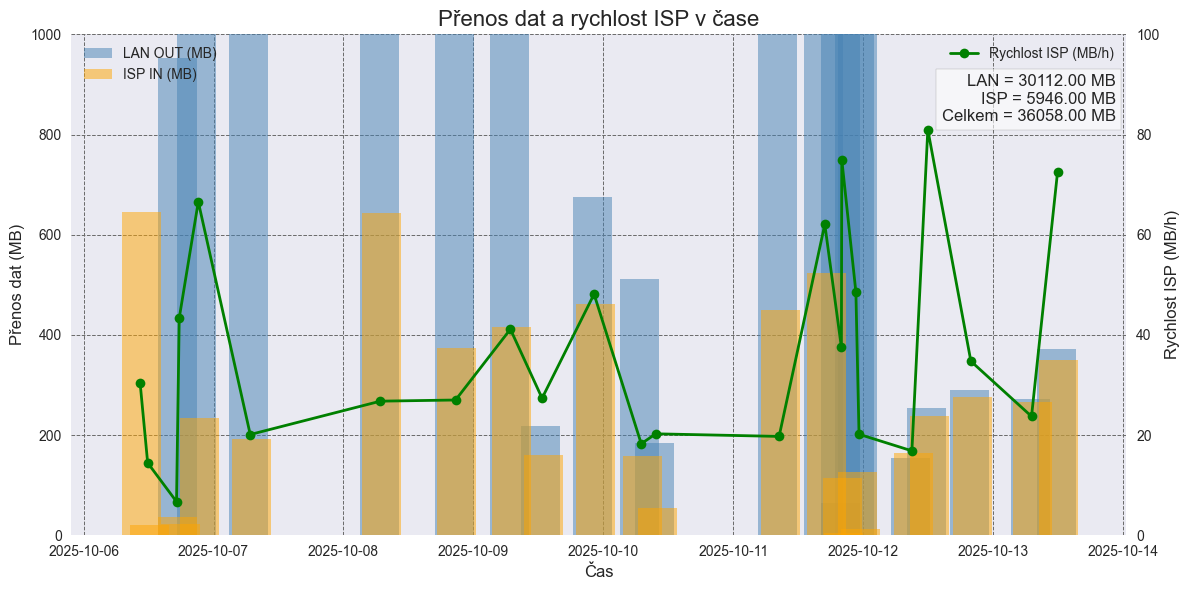

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# --- Načtení dat ---
df = pd.read_csv('/Users/Marek/tableau_project/Rx_Tx_new/traffic_log_dif.csv')
df['Time'] = pd.to_datetime(df['Time'], errors='coerce')

# --- Výpočty ---
df['ISP_Speed_MB_per_hr'] = (df['Delta_ISP_IN_MB'] / df['Delta_Time_hr']).round(2)
lan_sum = df["Delta_LAN_OUT_MB"].sum()
isp_sum = df["Delta_ISP_IN_MB"].sum()
total_sum = lan_sum + isp_sum

# --- Vykreslení ---
plt.style.use('seaborn-v0_8')
fig, ax1 = plt.subplots(figsize=(12, 6))

x = df['Time']
bar_width = 0.3
offset = pd.Timedelta(minutes=15) # sloupce vedle sebe

# Sloupcový graf na hlavní ose
ax1.bar(x - offset, df['Delta_LAN_OUT_MB'], width=bar_width, label='LAN OUT (MB)', color='steelblue', alpha=0.5)
ax1.bar(x + offset, df['Delta_ISP_IN_MB'], width=bar_width, label='ISP IN (MB)', color='orange', alpha=0.5)

ax1.set_ylabel('Přenos dat (MB)', fontsize=12)
ax1.legend(loc='upper left')

# Vedlejší osa pro rychlost
ax2 = ax1.twinx()
ax2.plot(x, df['ISP_Speed_MB_per_hr'], color='green', marker='o', linewidth=2, label='Rychlost ISP (MB/h)')
ax2.set_ylabel('Rychlost ISP (MB/h)', fontsize=12)
ax2.legend(loc='upper right')

# Popisky a souhrn
ax1.set_title('Přenos dat a rychlost ISP v čase', fontsize=16)
ax1.set_xlabel('Čas', fontsize=12)
plt.xticks(rotation=45)

summary = f"LAN = {lan_sum:.2f} MB\nISP = {isp_sum:.2f} MB\nCelkem = {total_sum:.2f} MB"
plt.text(0.99, 0.92, summary, transform=ax1.transAxes,
         fontsize=12, ha='right', va='top',
         bbox=dict(facecolor='white', alpha=0.6, edgecolor='gray'))

ax1.set_ylim(0, 1000)
ax2.set_ylim(0, 100)
ax1.grid(True, color='dimgray', linestyle='--', linewidth=0.7)
ax2.grid(False)

# --- Uložení a zobrazení ---
output_path = '/Users/Marek/tableau_project/Rx_Tx_new/graf_spotreba_a_rychlost.png'
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.tight_layout()
plt.savefig(output_path)
plt.show()
plt.close()